# Interactive dEB light curve viewing tool

In [1]:
from pathlib import Path
import re
from itertools import zip_longest

import numpy as np
import astropy.units as u
import lightkurve as lk

#%matplotlib widget 
import matplotlib.pyplot as plt
from matplotlib.axes import Axes

# Support for interactive widgets
from IPython.display import *
from ipywidgets import *

from libs import pipeline

#### Select your target
The `search_term` can be the well known object name or a TIC identifier (format "TIC #########").

In [2]:
target = "CW Eri"
search_term = "V* CW Eri"

#### Review Target Information and refine the search

In [3]:
# Find any lightcurve assets for the target, then filter the results by potential TESS sectors
# TODO: currently find_lightcurves() doesn't support multiple exptime versions of the same sector
results = lk.search_lightcurve(search_term)
results = results[(results.author == "SPOC")] # | (results.author == "TESS-SPOC")]
results = results[np.where(list("TESS" in m for m in results.mission), True, False)]

fmt = "{0}, {1}, author={2}, target={3}, exptime={4}"
display(VBox(children=(checkboxes := [
    Checkbox(description=fmt.format(r.mission[0], r.year[0], r.author[0], r.target_name[0], r.exptime[0]), value=True, layout={'width': "max-content"}) for r in results
])))

#### Download the light curves of the chosen sectors
For details of the flux_column and quality_bitmask arguments see the documentation for
[download](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.SearchResult.download.html#lightkurve.SearchResult.download).
The find_lightcurves() function will attempt to service the request from the
local cache in preference to contacting MAST.

In [4]:
display(HBox(children=[
    (flux_column     := widgets.Dropdown(options=["sap_flux", "pdcsap_flux"], value="sap_flux", description="flux_column :", style={'description_width': 'max-content'})),
    (quality_bitmask := widgets.Dropdown(options=["default", "hard", "hardest"], value="default", description="quality_bitmask :", style={'description_width': 'max-content'})),
]))

In [5]:
download_dir = Path.cwd() / ".cache" / re.sub(r"[^\w\d]", "-", target.lower())
selections = [checkboxes[i].value for i in range(len(checkboxes))]
sectors = [row["sequence_number"] for row, check in zip(results.table, selections) if check]

lcs = pipeline.find_lightcurves(search_term, download_dir, sectors, flux_column=flux_column.value,
                                quality_bitmask=quality_bitmask.value, force_mast=False, verbose=True)

Searching for light curves based on; search term=V* CW Eri, sectors=[4, 31], mission=TESS, author=SPOC and exptime=None
Looking for previously downloaded fits within /home/steveo/projects/main/platodebcat/.cache/cw-eri
Found 4 existing fits matching mission and author criteria
Found the required 2 fits file(s) meeting the TIC, sector & exptime criteria. Will load the requested light curves from these.


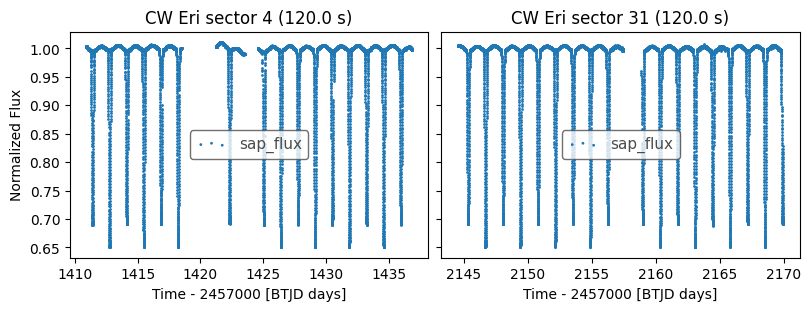

In [6]:
rows = int(np.ceil(len(lcs) / (cols := 2)))
fig, axes = plt.subplots(rows, cols, figsize=(8, 3*rows), sharey=True, constrained_layout=True)
axes = [axes] if isinstance(axes, Axes) else axes.flatten()

for ix, (ax, lc) in enumerate(zip_longest(axes, lcs)):
    if ix < len(lcs):
        lc.scatter(ax=ax, label=f"{lc.meta['FLUX_ORIGIN']}", normalize=True)
        ax.set_ylabel(None if ix % cols else ax.get_ylabel())
        ax.set_title(f"{target} sector {lc.meta['SECTOR']} ({lc.meta['FRAMETIM']*lc.meta['NUM_FRM'] * u.s})")
    else:
        ax.axis("off")
plt.show()
plt.close(fig) # Comment this out if using %matplotlib widget to enable interactive plot